In [4]:
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from torch.nn import Parameter
from scipy import interpolate
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.nn.init import kaiming_normal, calculate_gain
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

from model import *

In [5]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    use_gpu = torch.cuda.is_available()
    n_gpu = torch.cuda.device_count()
    print(f"GPU 数量: {n_gpu}")
print(f"运行平台: {device}")

GPU 数量: 1
运行平台: cuda


In [6]:
model = resnet50(num_classes=5)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
nums = [4000,3000,3000,3000,3000]

sample_total_train = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}
sample_total_valid = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}

for ip in range(5):
    class_name = classes[ip]
    num_sample = nums[ip]
    root_path = os.path.abspath('.')
    dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    # 混乱数据集
    random.shuffle(sample_name_list)
    num_data_sample = len(sample_name_list)
    # 训练集/验证集划分
    train_valid_ratio = 0.7999
    valid_num = int(num_data_sample * (1-train_valid_ratio))
    valid_list = random.sample(sample_name_list, valid_num)
    
    samples_train,samples_valid = [],[]
    for sample_name in sample_name_list[:num_sample]:
        if sample_name not in valid_list:
            samples_train.append(sample_name)
        else:
            samples_valid.append(sample_name)
    print(f'{class_name} 训练、验证样本数量：{len(samples_train)}, {len(samples_valid)}')
    sample_total_train[class_name] = samples_train
    sample_total_valid[class_name] = samples_valid

samples_file = os.path.join(os.path.join(root_path, "datasets"))
# np.save(os.path.join(samples_file,"samples_classification_train.npy"), sample_total_train)
# np.save(os.path.join(samples_file,"samples_classification_valid.npy"), sample_total_valid)

parallel 训练、验证样本数量：3200, 800
clinoform 训练、验证样本数量：2400, 600
fill 训练、验证样本数量：2400, 600
hummocky 训练、验证样本数量：2400, 600
chaotic 训练、验证样本数量：2400, 600


In [4]:
class build_dataset_classification(Dataset):
    def __init__(self, samples_list, samples_file,class_name):
        self.samples_list = samples_list
        self.dataset_path = os.path.join(samples_file, class_name + "_classification")
        self.class_name = class_name
        
    def __len__(self):
        return len(self.samples_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        classes = ["parallel","clinoform","fill","hummocky","chaotic"]
        sample_file_name = self.samples_list[idx]
        sample_file_path = os.path.join(self.dataset_path, sample_file_name + ".npy")
        sample = np.load(sample_file_path)
        sample = sample[np.newaxis,:,:]
        label = np.eye(5)[classes.index(self.class_name)]
        
        return  [sample,label]

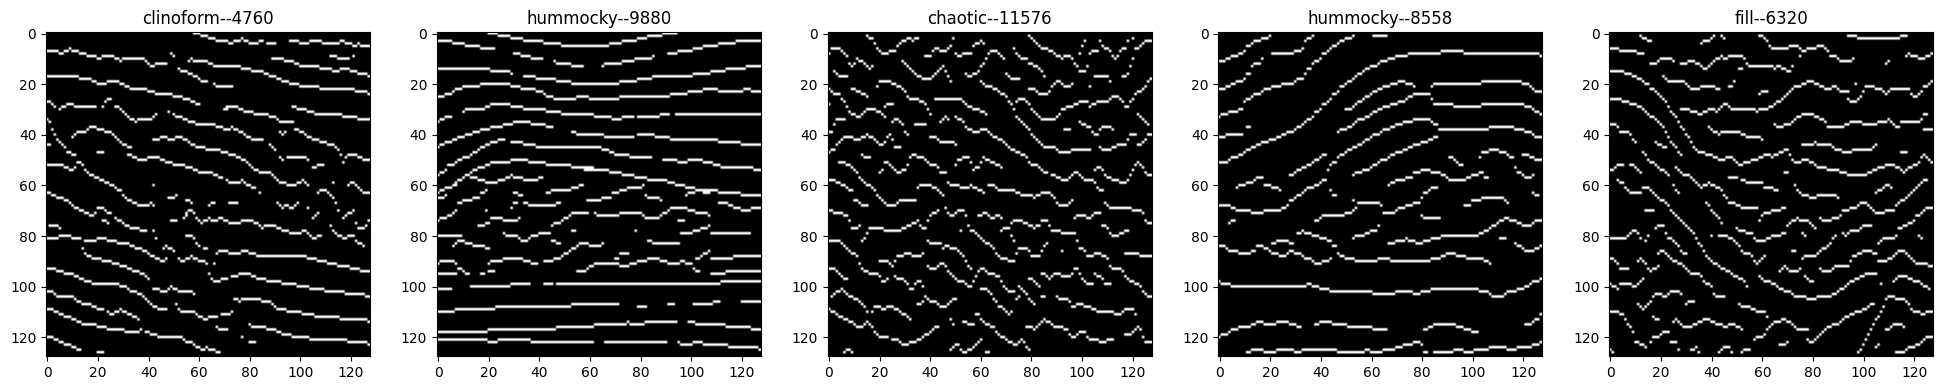

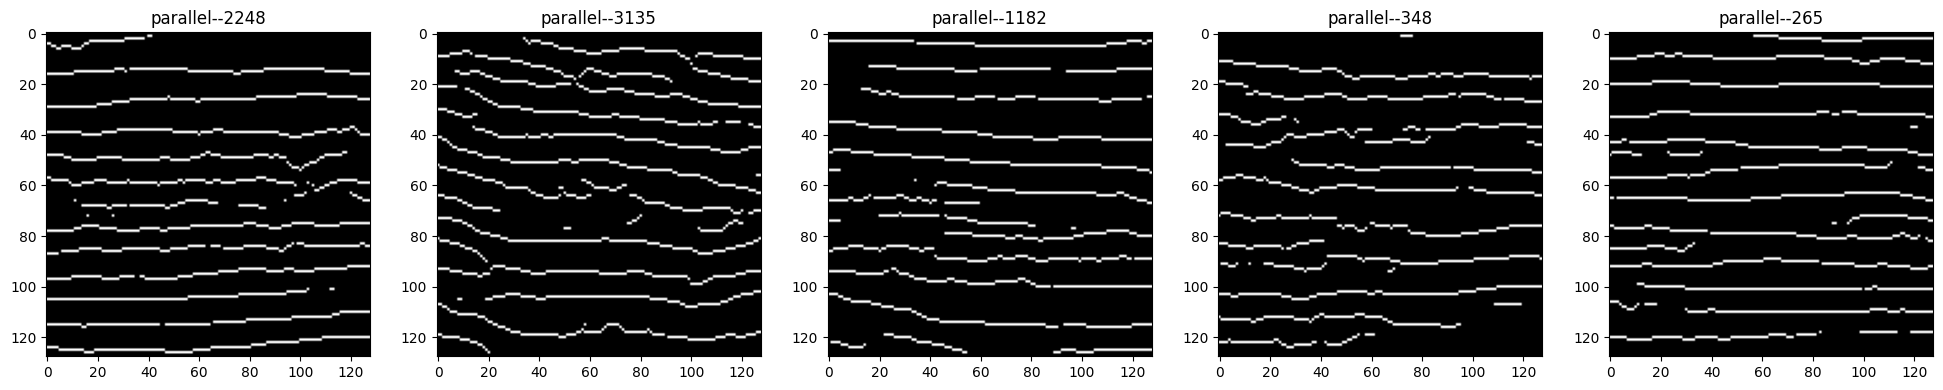

In [5]:
# visual
root_path = os.path.abspath('.')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_train = np.load(os.path.join(samples_file, "samples_classification_train.npy"), allow_pickle=True).item()
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # train
        samples_list_train = sample_total_train[class_name]
        samples_train_total = build_dataset_classification(samples_list_train,samples_file,class_name)
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # train
        samples_list_train = sample_total_train[class_name]
        samples_train = build_dataset_classification(samples_list_train,samples_file,class_name)
        samples_train_total = samples_train_total + samples_train
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid

idxs = np.random.randint(0, len(samples_train_total), size=5) 
batch_samples = [samples_train_total[i] for i in idxs]
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch_samples[i][0].squeeze(),cmap="gray")
    plt.title(str(classes[np.argwhere(batch_samples[i][1]==1)[0][0]])+"--"+str(idxs[i]))
    plt.tight_layout()
    
idxs = np.random.randint(0, len(samples_valid_total), size=5) 
# batch_samples = [samples_valid_total[i] for i in idxs]
batch_samples = [samples_valid_total[0],samples_valid_total[1],samples_valid_total[2],
                 samples_valid_total[3],samples_valid_total[4]]
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch_samples[i][0].squeeze(),cmap="gray")
    plt.title(str(classes[np.argwhere(batch_samples[i][1]==1)[0][0]])+"--"+str(idxs[i]))
    plt.tight_layout()

In [6]:
# load datasets
image_size = [1, 128, 128]
batch_size = 32

root_path = os.path.abspath('.')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_train = np.load(os.path.join(samples_file, "samples_classification_train.npy"), allow_pickle=True).item()
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # train
        samples_list_train = sample_total_train[class_name]
        samples_train_total = build_dataset_classification(samples_list_train,samples_file,class_name)
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # train
        samples_list_train = sample_total_train[class_name]
        samples_train = build_dataset_classification(samples_list_train,samples_file,class_name)
        samples_train_total = samples_train_total + samples_train
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid

train_loader = DataLoader(samples_train_total, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(samples_valid_total, batch_size=1, shuffle=False)

In [7]:
model = resnet50(num_classes=5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

loss_fn = nn.CrossEntropyLoss()
if use_gpu:
    print("use gpu for training")
    generator = model.cuda()
    loss_fn = loss_fn.cuda()

use gpu for training


In [8]:
# Training
num_epoch = 201
checkpoint_path = "./Network_path/classification_DDE_agument/"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
print(checkpoint_path)

epoch_loss_train,epoch_loss_valid,epoch_lr = [],[],[]
best_mse = 1e50

for epoch in range(num_epoch):
    # training
    model.train()
    loss_train_per_epoch = 0
    for i, mini_batch in enumerate(train_loader):
        data = torch.tensor(mini_batch[0],dtype=torch.float32)
        label = torch.tensor(mini_batch[1],dtype=torch.float32)
        if use_gpu:
            data = Variable(data).to("cuda")
            label = Variable(label).to("cuda")
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_fn(pred,label)
        loss.backward()
        optimizer.step()
        loss_train_per_epoch += loss
        
    # validation
    model.eval()
    loss_valid_per_epoch = 0
    with torch.no_grad():
        for i, mini_batch in enumerate(valid_loader):
            data = torch.tensor(mini_batch[0],dtype=torch.float32)
            label = torch.tensor(mini_batch[1],dtype=torch.float32)
            if use_gpu:
                data = Variable(data).to("cuda")
                label = Variable(label).to("cuda")
            pred = model(data)
            loss = loss_fn(pred,label)
            loss_valid_per_epoch += loss
            
    loss_train_per_epoch = loss_train_per_epoch / len(train_loader)
    loss_valid_per_epoch = loss_valid_per_epoch / len(valid_loader)
    epoch_loss_train.append(loss_train_per_epoch)
    epoch_loss_valid.append(loss_valid_per_epoch)
    epoch_lr.append(optimizer.param_groups[0]['lr'])
    
    scheduler.step(loss_train_per_epoch)
    
    # 保存模型
    if epoch % 10 == 0:
        state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        filename = os.path.join(checkpoint_path, 'checkpoint-epoch{}.pth'.format(epoch))
        torch.save(state, filename)
    
    # 保存最优模型
    if loss_valid_per_epoch < best_mse:
        state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        filename = os.path.join(checkpoint_path, 'checkpoint-best.pth')
        torch.save(state, filename)
        best_mse = loss_valid_per_epoch
        
    # 显示loss
    if epoch % 1 == 0:
        print("Epoch:{}, Training Loss:{:.5f}, Validation Loss:{:.5f}, Learning rate: {:.5f}".format(
            epoch, loss_train_per_epoch, loss_valid_per_epoch, epoch_lr[epoch]))

./Network_path/classification_DDE_agument/
Epoch:0, Training Loss:0.85804, Validation Loss:1.15484, Learning rate: 0.01000
Epoch:1, Training Loss:0.32405, Validation Loss:0.52745, Learning rate: 0.01000
Epoch:2, Training Loss:0.26921, Validation Loss:0.22324, Learning rate: 0.01000
Epoch:3, Training Loss:0.24967, Validation Loss:0.35316, Learning rate: 0.01000
Epoch:4, Training Loss:0.21662, Validation Loss:0.18424, Learning rate: 0.01000
Epoch:5, Training Loss:0.19916, Validation Loss:0.23477, Learning rate: 0.01000
Epoch:6, Training Loss:0.18060, Validation Loss:0.36083, Learning rate: 0.01000
Epoch:7, Training Loss:0.16513, Validation Loss:0.17577, Learning rate: 0.01000
Epoch:8, Training Loss:0.15155, Validation Loss:0.47909, Learning rate: 0.01000
Epoch:9, Training Loss:0.15324, Validation Loss:0.13881, Learning rate: 0.01000
Epoch:10, Training Loss:0.14522, Validation Loss:0.14925, Learning rate: 0.01000
Epoch:11, Training Loss:0.13334, Validation Loss:0.56822, Learning rate: 0.0

Epoch:101, Training Loss:0.00620, Validation Loss:0.10968, Learning rate: 0.00002
Epoch:102, Training Loss:0.00685, Validation Loss:0.10949, Learning rate: 0.00002
Epoch:103, Training Loss:0.00693, Validation Loss:0.10857, Learning rate: 0.00002
Epoch:104, Training Loss:0.00673, Validation Loss:0.11044, Learning rate: 0.00001
Epoch:105, Training Loss:0.00590, Validation Loss:0.11002, Learning rate: 0.00001
Epoch:106, Training Loss:0.00622, Validation Loss:0.11008, Learning rate: 0.00001
Epoch:107, Training Loss:0.00639, Validation Loss:0.10797, Learning rate: 0.00001
Epoch:108, Training Loss:0.00705, Validation Loss:0.10918, Learning rate: 0.00001
Epoch:109, Training Loss:0.00558, Validation Loss:0.10943, Learning rate: 0.00000
Epoch:110, Training Loss:0.00561, Validation Loss:0.10779, Learning rate: 0.00000
Epoch:111, Training Loss:0.00707, Validation Loss:0.10922, Learning rate: 0.00000
Epoch:112, Training Loss:0.00603, Validation Loss:0.10985, Learning rate: 0.00000
Epoch:113, Train

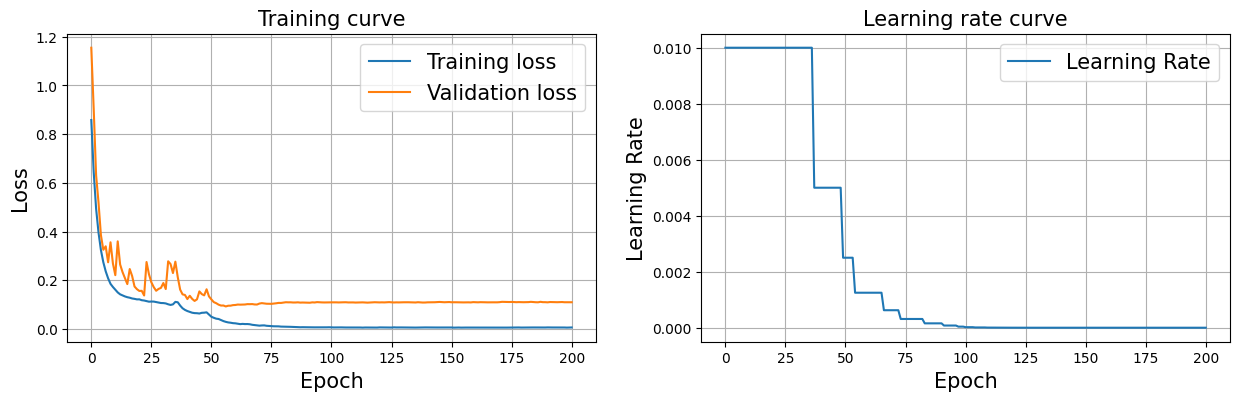

In [9]:
# 曲线光滑函数
def smooth(v, w=0.85):
    last = v[0]
    smoothed = []
    for point in v:
        smoothed_val = last * w + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed 

# 训练loss曲线
for i in range(len(epoch_loss_train)):
    epoch_loss_train[i] = epoch_loss_train[i].cpu().detach().numpy()
    epoch_loss_valid[i] = epoch_loss_valid[i].cpu().detach().numpy()
    epoch_lr[i] = epoch_lr[i]
    
x = [i for i in range(num_epoch)]
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, smooth(epoch_loss_train, 0.6), label='Training loss')
ax.plot(x, smooth(epoch_loss_valid, 0.6), label='Validation loss')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_title(f'Training curve', fontsize=15)
ax.grid(True)
plt.legend(loc='upper right', fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, epoch_lr,  label='Learning Rate')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Learning Rate', fontsize=15)
ax.set_title(f'Learning rate curve', fontsize=15)
ax.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()

logs = {"epoch_loss_train":epoch_loss_train,
        "epoch_loss_valid":epoch_loss_valid,
        "epoch_lr":epoch_lr}
np.save(os.path.join(checkpoint_path, 'logs.npy'), logs)

In [10]:
quit()